In [1]:
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tnrange

from utils import Manuscript
ms = Manuscript('figures')

Run this Notebook from the command line with:

    jupyter nbconvert --execute Manuscript.ipynb --to notebook --output Manuscript.ipynb

If it complains about NoSuchKernel, add your current environment to the kernelspec, e.g.:

    python -m ipykernel install --name myenv

Make this manuscript into pure Markdown with:

    jupyter nbconvert Manuscript.ipynb --to markdown --output Manuscript.md \
    --TagRemovePreprocessor.remove_input_tags={\"hidein\"} \
    --TagRemovePreprocessor.remove_all_outputs_tags={\"hideout\"} \
    --TagRemovePreprocessor.remove_cell_tags={\"hide\"} 

Then to convert to other formats:

    pandoc Manuscript.md -o Manuscript.pdf

or

    pandoc Manuscript.md -o Manuscript.docx

### GEOPHYSICAL TUTORIAL, August 2018

# Neural networks
*by [GRAM](https://gra.m-gan.sl), Head of Data Science, Expero Inc*

There's no magic here. 

We've all heard a proselytizing hyperbolist make the an-AI-is-going-to-steal-my-job speech. If you subscribe, look at the following code cell. It demonstrates all the tenets of deep learning. You'll find a simple system composed exclusively of multiply and add operations. That's all that happens inside a neural network. Multiply and add.

A neural network is nothing but a nonlinear system of equations like $\mathbf{y} = \sigma(\mathbf{W}\mathbf{X} + \mathbf{b})$. Seriously. 

> MH: I accept what you say about backprop not being required to define a neural net... but I feel like you need a sentence here introducing backprop, because the next block of text mentions it.

The nonlinearity is introduced by the sigmoid function:

$$ \sigma(z) = \frac{1}{1 + \operatorname{e}^{-z}} $$

Here's the same function in Python:

In [2]:
def sigma(z, forward=True):
    if forward:
        return 1 / (1 + np.exp(-z))
    else:
        return z * (1 - z)

Notice that we provide two alternative paths in the Python function: one for the forward pass of the data through the network, and another path for the so-called 'backpropagation' step, when we need the derivative of the sigmoid:

$$ \frac{\partial \sigma(z)}{\partial z} = z  (1 - z) $$

Another common activation function is the $\operatorname{tanh}$ function. We'll stick with the sigmoid for now, but here's $\operatorname{tanh}$, for your reference:

In [3]:
def tanh(z, forward=True):
    if forward:
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) 
    else:
        return 1 - tanh(z)**2

Yet another is the ReLU, or rectified linear unit, function:

In [4]:
def relu(z, forward=True):
    if forward:
        return z * (z > 0) 
    else:
        return 1 * (z > 0)

## Define the network

We are now ready to implement the neural network itself. Neural networks consist of three or more 'layers': an input layer, one or more 'hidden' layers, and an output layer.

Let's implement a network with one hidden layer. The layers are as follows:

$$ \text{Input layer:}\ \ \mathbf{X} $$

$$ \text{Hidden layer:}\ \ \mathbf{a}_1 = \sigma ( \mathbf{W}_1 \cdot \mathbf{X} + \mathbf{b}_1) $$

$$ \text{Output layer:}\ \ \hat{\mathbf{y}} = \mathbf{W}_2 \cdot \mathbf{a}_1 + \mathbf{b}_2 $$

where $\mathbf{X}$ is the input data, $\mathbf{W}_1, \mathbf{W}_2, \mathbf{b}_1, \mathbf{b}_2$ are weight and bias vectors for layers 1 and 2 respectively, and $\sigma$ is a nonlinear function (we're using the "sigmoid" or "logistic" function, but people use lots of others). Applying the nonlinearity to $\mathbf{W}_1 \cdot \mathbf{X} + \mathbf{b}_1$ in layer 1 results in the 'activation' $\mathbf{a}_1$. The output layer yields $\hat{\mathbf{y}}$, the estimate of the desired output. We're not going to apply the nonlinearrity to the output, but people often do.

We're ready to implement this in Python:

In [5]:
def forward(X, W1, b1, W2, b2):
    z1 = W1 @ X + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    return z2, a1

Here's a picture of a neural network similar to the one we're building:

![image](nn_diagram.png)

Here we see a simple neural network which takes 3 numbers as input (the blue neurons) and outputs one number (the red neuron). In the middle (the orange neurons) we have a so-called "hidden layer," which in this case has 5 neurons or "units". Moving information from input layer, to hidden layer, to output layer is as simple as matrix multiplying and adding numbers. In the middle we apply a sigmoid function to each of the numbers.

In this tutorial, we'll train a model like this to learn the Zoeppritz solution for P–P reflections. Instead of 3 inputs, we'll use 7: $V_\mathrm{P}$, $V_\mathrm{S}$ and $\rho$ for the upper and lower layer properties at each interface, plus the angle of incidence, $\theta$ at each interface. And instead of 5 units in the hidden layer, we'll use 300. 

We can "teach" this simple system to model a mapping between one set of numbers and another set. For example, we can train this system to output a one when we input a one, a two when we input a two, and an N when we input an N. This is equivalent to building a linear model. More interestingly, we could teach it to output a nonlinear model: one maps to one, two maps to four, and N maps to $N^2$.

How does the network "learn?" The short version is that we show the system a bunch of corresponding input/output pairs we want it to learn, and we show it these pairs thousands of times. Every time we do so, we move the **W**'s and **b**'s in whatever direction makes the outputs of the network more similar to the known output we're trying to teach it. 

The iterative adjustment of weights and biases relies on a process called "backpropagation of errors".

Backpropagation is the critical piece of thinking which enabled the deep learning revolution. It is the reason Google can translate from Hindi to English. It is the reason the exchange of securities on public markets is no longer performed primarily by humans. It is the reason we can predict the failure of drilling equipment days in advance of failure (see my video at http://bit.ly/2Ks5tQf for more on this).

Here is the backpropagation algorithm we'll apply:

    For each training example:

        For each layer:

          - Calculate the error.
          - Calculate weight gradient.
          - Update weights.
          - Calculate the bias gradient.
          - Update biases.

This is straightforward for the output layer. However, to calculate the gradient on the hidden layer, we need to compute the gradient of the activations $\mathbf{a}_1$ of the hidden layer. That's why we needed the other path in the `forward()` function.

Let's implement this as a Python function:

In [57]:
def backward(xi, yi,
             a1, z2,
             params,
             learning_rate):

    # We need to remember W2 before changing it.
    W2 = params['W2']
    
    delta_output = z2 - yi
    grad_W2 = delta_output * a1
    params['W2'] -= learning_rate * grad_W2

    grad_b2 = delta_output
    params['b2'] -= learning_rate * grad_b2

    derivative = sigma(a1, forward=False)
    delta_hidden = delta_output * derivative * W2
    grad_W1 = delta_hidden.reshape((-1, 1)) @ xi.reshape((1, -1))
    params['W1'] -= learning_rate * grad_W1
    
    grad_b1 = delta_hidden
    params['b1'] -= learning_rate * grad_b1
    
    return params

To demonstrate this backpropagation workflow, and thus that our system can learn, let's try to get the above neural network to learn the Zoeppritz equation. We're going to need some data.

## Training data

We could make up some data, but it's more fun to use real logs.

Let's load some logs! We'll make a training set that only contains 400 data samples — that is, 400 instances of each set of features. 

In [114]:
n = 1000

In [115]:
from welly import Well

w = Well.from_las("R-39.las")

VP = 1e6 / w.data['DT4P'][:-100]
VS = 1e6 / w.data['DT4S'][:-100]
RHO = w.data['RHOB'][:-100]
Z = RHO.basis

# There is some dodgy data in the VS log
VS[VS<0] = np.mean(VS)

vp = VP[::5][:n+1]
vs = VS[::5][:n+1]
rho = RHO[::5][:n+1]

z = Z[::5][:n+1]

vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

We'll compute the exact Zoeppritz solution for our logs using a lot of random offsets up to 20 degrees. This way, hopefully the network will learn to compute the reflectivity of an interface at a given offset.

Make a random sequence of values to use for the angle of incidence:

In [116]:
np.random.seed(42)
min_theta = 0
max_theta = 20
theta = np.random.random(n) * (max_theta - min_theta) + min_theta

Here's the range of thetas we're going to train on:

In [117]:
np.min(theta), np.max(theta)

(0.092640460092057175, 19.994353465722611)

Now we can make the feature matrix `X`. We make a matrix by stacking all the NumPy arrays, then use Scikit-Learn's `StandardScaler` to scale the features to a zero mean with a standard deviation of 1.

In [118]:
from sklearn.preprocessing import StandardScaler

features = [vp1, vs1, rho1, vp2, vs2, rho2, theta]
X_ = np.stack(features, axis=-1)

scaler = StandardScaler().fit(X_)
X = scaler.transform(X_)

Make the label vector `y`:

In [119]:
from bruges.reflection import zoeppritz_rpp

y_ = [zoeppritz_rpp(*xi[:-1], theta1=xi[-1]) for xi in X_]
y = np.array(y_).real

Some quality checking of `X` and `y`:

In [120]:
print(X.shape, y.shape)

(1000, 7) (1000,)


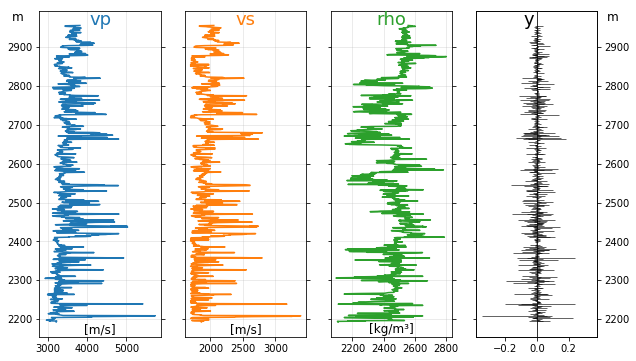

In [121]:
fig, axs = plt.subplots(figsize=(10, 6), ncols=4)

ax = axs[0]
ax.plot(vp, z, c='C0')
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(axs[0].get_xlim()), axs[0].get_ylim()[1]-1, "vp", fontsize=18, color="C0", ha='center', va='top')
ax.text(np.mean(axs[0].get_xlim()), axs[0].get_ylim()[0]+1, "[m/s]", fontsize=12, ha='center', va='bottom')
ax.text(axs[0].get_xlim()[0]-400, axs[0].get_ylim()[1], "m", fontsize=12, ha='right', va='top')
ax.grid(alpha=0.3)

ax = axs[1]
ax.plot(vs, z, c='C1')
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(axs[1].get_xlim()), axs[1].get_ylim()[1]-1, "vs", fontsize=18, color="C1", ha='center', va='top')
ax.text(np.mean(axs[1].get_xlim()), axs[1].get_ylim()[0]+1, "[m/s]", fontsize=12, ha='center', va='bottom')
ax.grid(alpha=0.3)

ax = axs[2]
ax.plot(rho, z, c='C2')
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]-1, "rho", fontsize=18, color="C2", ha='center', va='top')
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[0]+1, "[kg/m³]", fontsize=12, ha='center', va='bottom')
ax.grid(alpha=0.3)

ax = axs[3]
ax.hlines(z, 0, y, lw=0.6)
ax.axvline(0, color='k', lw=0.8)
ax.axes.yaxis.set_ticklabels([])
ma = 1.1 * np.max(np.abs(y))
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]-1, "y", fontsize=18, color="k", ha='center', va='top')
ax.set_xlim(-ma, ma)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax.text(ax.get_xlim()[1]+0.13, ax.get_ylim()[1], "m", fontsize=12, ha='right', va='top')

plt.show()

In [122]:
n_train = 800

indices = list(range(len(X)))
np.random.shuffle(indices)
X_train, y_train = X[indices[0:n_train]], y[indices[0:n_train]]
X_val, y_val = X[indices[n_train:]], y[indices[n_train:]]

In [137]:
X_train.shape, X_val.shape

((800, 7), (200, 7))

After processing the data, we have a feature matrix `X` with shape 200 &times; 7, and a label vector `y` with 200 elements. The feature matrix has one row for each data sample, and one column for each feature. The features are $V_\mathrm{P}$, $V_\mathrm{S}$, and $\rho$ for the upper and lower layer at each sample, plus the angle of incidence &mdash; 7 features in all. The labels in `y` are the reflectivities calculated from each set of features.

## Train the network

Now we can initialize the weights and biases for our network:

In [66]:
from numpy.random import randn

In [124]:
def initialize_params(units, features):
    np.random.seed(42)
    params = {
        "W1": 0.1 * randn(units, features),
        "b1": np.zeros(shape=units),

        "W2": 0.1 * randn(units),
        "b2": np.zeros(shape=1)
    }
    return params

In [125]:
units = 300
features = 7

params = initialize_params(units, features)

Right away, we can pass the data through the untrained network. It won't predict anything useful, but we can look at the result later to see the difference the training made.

In [126]:
pre_train = []
for xi in X:
    y_pred, _ = forward(xi, **params)
    pre_train.append(np.asscalar(y_pred))

One at a time, we expose the network to the input/output pairs (these are labeled x and y respectively in the code). According to our diagram above, the input goes into the green slot and we adjust the orange neurons to make the red slot output from the network a tiny bit closer (0.1%) to the true Zoeppritz result.

We do this 2,000 times. Every time we do, we output the mean squared error between the network's prediction and the ground-truth output from the Zoeppritz function. After these twenty thousand iterations, or "epochs", we draw out a plot which shows that loss at each step. If the network is learning anything, we expect the loss to decrease, as the predictions are getting closer to the ground truth.

In [135]:
num_epochs = 100
learning_rate = 0.001
loss_history, loss_val_history = [], []

params = initialize_params(units, features)

data = list(zip(X_train, y_train))
data_val = list(zip(X_val, y_val))

for i in tnrange(num_epochs):
    
    # Training.
    np.random.shuffle(data)
    loss = 0
    
    for xi, yi in data:
        z2, a1 = forward(xi, **params)

        params = backward(xi, yi,
                          a1, z2,
                          params,
                          learning_rate)
        
        loss += np.square(z2 - yi)

    loss_history.append(loss/y_train.size)

    # Validation.
    np.random.shuffle(data_val)
    loss_val = 0

    for xi, yi in data_val:
        z2, a1 = forward(xi, **params)
        loss_val += np.square(z2 - yi)

    loss_val_history.append(loss/y_val.size)

A Jupyter Widget

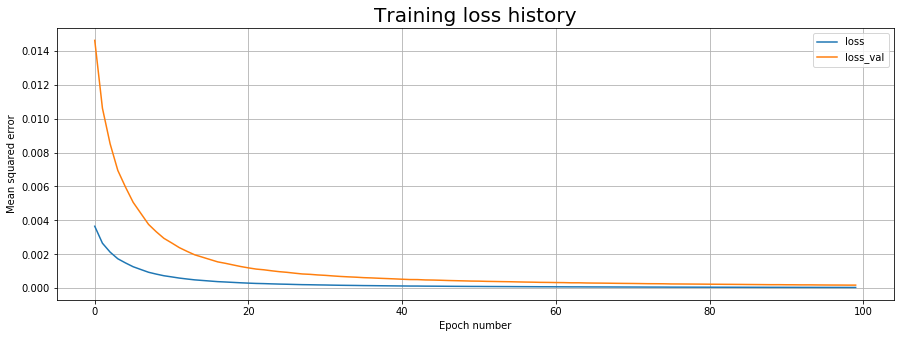

In [136]:
plt.figure(figsize=(15,5))

plt.plot(loss_history, label='loss')
plt.plot(loss_val_history, label='loss_val')

plt.title('Training loss history', fontsize=20)
plt.xlabel('Epoch number')
plt.ylabel('Mean squared error')
plt.grid()
plt.legend()
plt.show()

The loss decreased dramatically over the course of twenty thousand epochs, so presumably the network has learned something. To test this theory, we'll plot a bunch of network outputs before and after training.

Note that in the next code block that we're actually feeding the network inputs which it hasn't been trained on. In particular, some of these inputs are outside the "span of the input domain," which simply means we're feeding in values outside the [0, 2$\pi$] values we trained on. This is an important concept in statistical modeling known as the "generalizability" of a model.

In [138]:
post_train = []
for xi in X:
    y_pred, _ = forward(xi, **params)
    post_train.append(np.asscalar(y_pred))

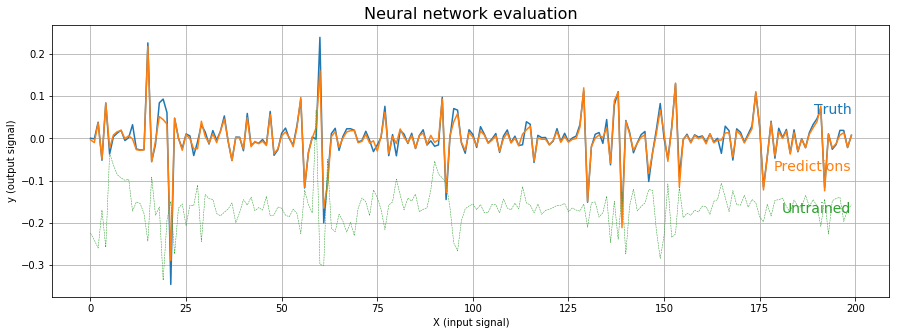

In [141]:
#
plt.figure(figsize=(15,5))
plt.title('Neural network evaluation', fontsize=16)
plt.xlabel('X (input signal)')
plt.ylabel('y (output signal)')

plt.plot(y[:200], label='groundtruth')
plt.plot(post_train[:200], label='predictions')
plt.plot(pre_train[:200], '--', label='untrained predictions', lw=0.5)

#plt.scatter(blind, blind_preds, color='red', label='interesting predictions')
plt.text(199, 0.05, "Truth", color='C0', fontsize=14, va='bottom', ha='right')
plt.text(199, -0.05, "Predictions", color='C1', fontsize=14, va='top', ha='right')
plt.text(199, -0.15, "Untrained", color='C2', fontsize=14, va='top', ha='right')

plt.grid()
plt.show()
#plt.savefig('output.png', dpi=300)

## Blind test: new rocks

The chart above shows the result of applying the neural network to the same data that it trained on, so it's no wonder it fits quite well. Let's test the network on new data it has not seen before. We'll use the higher-impedance rocks from near the bottom of the same well. 

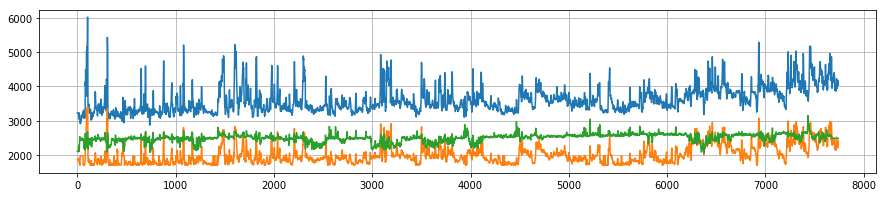

In [142]:
plt.figure(figsize=(15, 3))
plt.plot(VP)
plt.plot(VS)
plt.plot(RHO)
plt.grid()

In [143]:
n = 200

vp = VP[::5][-n-1:]
vs = VS[::5][-n-1:]
rho = RHO[::5][-n-1:]

vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

In [144]:
theta = 30
theta_ = np.ones(n) * theta

y_blind = zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=theta)
X_blind_ = np.vstack([vp1, vs1, rho1, vp2, vs2, rho2, theta_]).T

X_blind = scaler.transform(X_blind_)

In [147]:
blind_pre = []
for xi in X_blind:
    y_pred, _ = forward(xi, **initialize_params(units, features))
    blind_pre.append(np.asscalar(y_pred))

In [148]:
blind_train = []
for xi in X_blind:
    y_pred, _ = forward(xi, **params)
    blind_train.append(np.asscalar(y_pred))

In the plot below, the blue line is the true Zoeppritz result. The green line is the output from the network before training (i.e. with random weights). The orange line is the output from the network after training (i.e. after the weights have been learned).

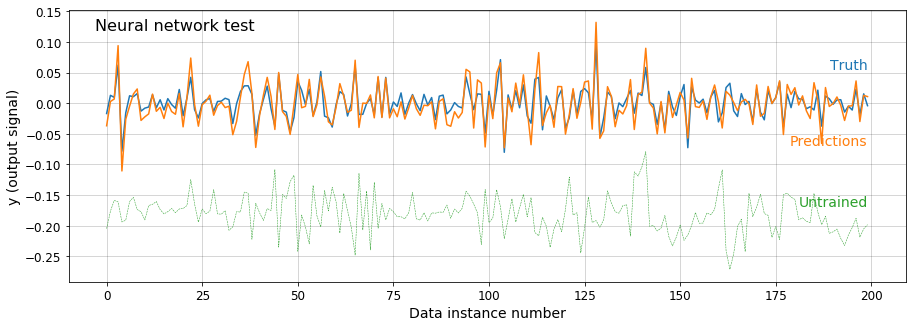

In [149]:
plt.figure(figsize=(15,5))

plt.plot(y_blind.real, label='Truth')
plt.plot(blind_train, label='Predictions')
plt.plot(blind_pre, '--', label='Untrained', lw=0.5)

plt.text(-3, 0.12, 'Neural network test', fontsize=16, ha='left')
plt.xlabel('Data instance number', fontsize=14)
plt.ylabel('y (output signal)', fontsize=14)

plt.text(199, 0.05, "Truth", color='C0', fontsize=14, va='bottom', ha='right')
plt.text(199, -0.05, "Predictions", color='C1', fontsize=14, va='top', ha='right')
plt.text(199, -0.15, "Untrained", color='C2', fontsize=14, va='top', ha='right')

plt.gca().tick_params(axis='both', labelsize=12)

plt.grid(color='k', alpha=0.2)
plt.show()

So, indeed, our neural network has learned to approximate the Zoeppritz equation!

## Blind test: new angles

As well as predicting the reflectivity for rocks we did not train on, we can try predicting reflectivity at angles we did not train on. We'll look at the AVO response at a single interface and see how it compares to the exact solution:

In [150]:
def get_amps(data, sample, theta):
    
    amp = zoeppritz_rpp(*data[sample, :-1], theta1=theta).real

    amp_hat = []
    for t in theta:
        xi = np.hstack([data[sample, :-1], [t]])
        xi = scaler.transform(xi.reshape(1, -1))
        amp_, _ = forward(np.squeeze(xi), **params)
        amp_hat.append(amp_)
        
    return amp, amp_hat

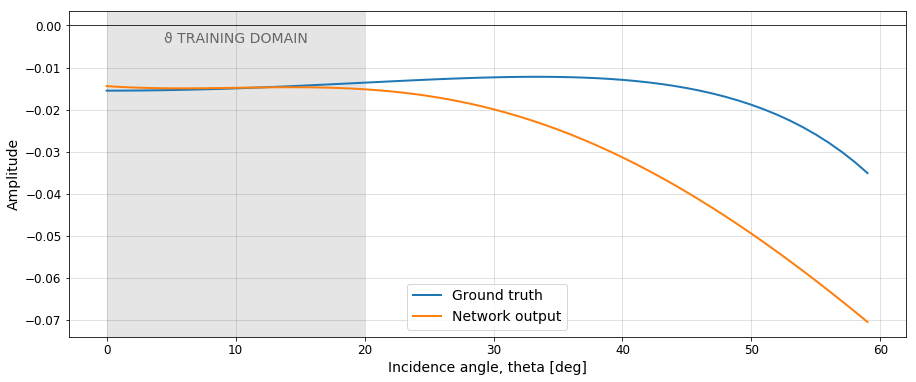

In [151]:
theta = np.arange(60)
amp, amp_hat = get_amps(X_blind_, sample=82, theta=theta)
    
plt.figure(figsize=(15, 6))

plt.plot(theta, amp, label="Ground truth", lw=2)
plt.plot(theta, amp_hat, label="Network output", lw=2)

plt.axvspan(min_theta, max_theta, facecolor='k', alpha=0.1, lw=0)
plt.axhline(0, lw=0.75, color='k')
plt.text(np.mean([min_theta, max_theta]), plt.gca().get_ylim()[1]-0.005,
         s = "ϑ TRAINING DOMAIN",
         fontsize=14, color=(0.4, 0.4, 0.4),
         va='top', ha='center')

plt.grid(color='k', alpha=0.15)
plt.xlabel('Incidence angle, theta [deg]', size=14)
plt.ylabel('Amplitude', size=14)
plt.gca().tick_params(axis='both', labelsize=12)
plt.legend(fontsize=14)
plt.show()

Not surprisingly, the network is at least in the right ballpark inside the range of angles over which it trained. But it doesn't do all that well outside that range. More training is needed!

## Summary

That's it. That's all of deep learning. Multiply, add, apply nonlinearity. No magic. No "intelligence". Just simple arithmetic. Told you.

## Acknowledgments

Thanks to Expero for encouraging me to continue to publish.

Thanks to Matt Hall for continuously pushing our professional community to modernize with efforts like the one you're reading now.

Thanks to Lukas Mosser and Jesper Dramsch for helpful feedback on the draft of this manuscript.

## Challenges for the reader

- Can you stop the training if the MSE falls below some acceptable level?
- Vary the range of theta over which you train the network.
- Try swapping `sigmoid` for a different [activation function](https://en.wikipedia.org/wiki/Activation_function), e.g. tanh or ReLu.
- Add another hidden layer.
- Add regularization.
- Train on batches of input data, only updating the weights after every 10 or 100 training instances.
- Implement this network in PyTorch or Keras.